In [142]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

### 1. Préparation des données

In [143]:
df_data = pd.read_csv('../data/train.csv')
df_data.head(1)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.0,0.00293,0.00293,0.035156,0.0,0.0,0.004883,0.0,0.025391


In [144]:
X = ((df_data.iloc[:,2:] - df_data.iloc[:,2:].min()) / (df_data.iloc[:,2:].max() - df_data.iloc[:,2:].min())).values
#X = df_data.copy().drop(['id', 'species'],axis='columns').values


species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros(df_data.shape[0])
for i in range(species.size):
    t[df_data['species'] == species[i]] = i

In [145]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

In [146]:
#création des listes des valeurs d'hyper-paramètres possibles et choix du maximum d'itérations
all_values_lr = np.logspace(-9, 0, 10)
all_values_alpha = np.logspace(-9, 0, 10)
max_iter = 10000

### 2. Perceptron sans optimisation de paramètres

In [147]:
# création d'un classifieur multiclasse de type perceptron
classifieur_perceptron = Perceptron(alpha =0, eta0= 0.001, penalty=None, random_state=0)   
classifieur_perceptron.fit(X_train, t_train)

Perceptron(alpha=0, eta0=0.001)

In [148]:
print("Score X_train, t_train : {:.2f}%".format(classifieur_perceptron.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(classifieur_perceptron.score(X_test, t_test)*100))

Score X_train, t_train : 97.84%
Score X_test, t_test : 88.89%


### 3. Perceptron sans optimisation de paramètres avec une pénalité L2

In [149]:
classifieur_reg = Perceptron(penalty='l2')    
classifieur_reg.fit(X_train, t_train)

Perceptron(penalty='l2')

In [150]:
print("Score X_train, t_train : {:.2f}%".format(classifieur_reg.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(classifieur_reg.score(X_test, t_test)*100))

Score X_train, t_train : 91.63%
Score X_test, t_test : 86.53%


### 4. Perceptron avec optimisation des paramètres

In [151]:
# Paramètre à tester
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Création du modèle de recherche sur grille
grid_search_perceptron = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=3, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_perceptron.fit(X_train, t_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done


In [152]:
results_grid_perceptron = pd.DataFrame.from_dict(grid_search_perceptron.cv_results_)

In [153]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_perceptron.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(grid_search_perceptron.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(grid_search_perceptron.score(X_train, t_train)*100))

Meilleur paramètre: {'alpha': 1e-09, 'eta0': 1.0}
Meilleure précision sur un split : 90.33%
Score X_train, t_train : 100.00%


### 5. Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

In [154]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1, figsize = (8,6))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.semilogx(grid_param_1, scores_mean[:,idx], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores CV = 3", fontsize=10, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=10)
    ax.set_ylabel('CV Average Score', fontsize=10)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
    ax.grid('on')

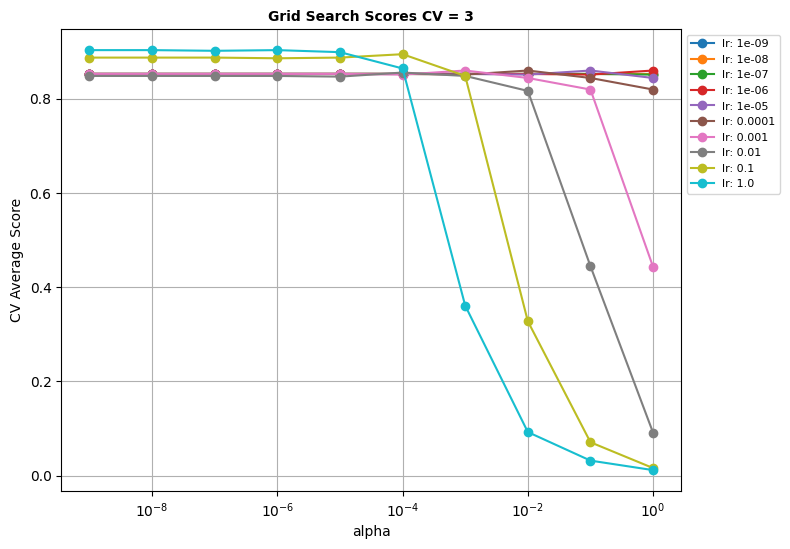

In [155]:
plot_grid_search(results_grid_perceptron, all_values_alpha, all_values_lr, 'alpha', 'lr')

### 6. Test du perceptron sur nos données test

In [156]:
print("Score X_test, t_test : {:.2f}%".format(grid_search_perceptron.score(X_test, t_test)*100))

Score X_test, t_test : 93.27%


### 7. Utilisation de notre perceptron en isolant chaque features : Margin / Shape / Textures

### 7.1 Préparation des données

In [157]:
X_train_margin = X_train[:,:64]
X_test_margin = X_test[:,:64]

In [158]:
X_train_shape = X_train[:,64:128]
X_test_shape = X_test[:,64:128]

In [159]:
X_train_texture = X_train[:,128:]
X_test_texture = X_test[:,128:]

### 7.2 Recherche du meilleur modèle pour chaque feature
### 7.2.1 Margin :

In [160]:
# Paramètre à tester
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Création du modèle de recherche sur grille
perceptron_margin = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=3, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
perceptron_margin.fit(X_train_margin, t_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done


In [161]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", perceptron_margin.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(perceptron_margin.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(perceptron_margin.score(X_train_margin, t_train_margin)*100))
print("Score X_test, t_test : {:.2f}%".format(perceptron_margin.score(X_test_margin, t_test_margin)*100))

Meilleur paramètre: {'alpha': 1e-06, 'eta0': 1.0}
Meilleure précision sur un split : 54.69%
Score X_train, t_train : 80.23%
Score X_test, t_test : 50.84%


### 7.2.2 Shape : 

In [162]:
# Paramètre à tester
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Création du modèle de recherche sur grille
perceptron_shape = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=3, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
perceptron_shape.fit(X_train_shape, t_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done


In [163]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", perceptron_shape.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(perceptron_shape.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(perceptron_shape.score(X_train_shape, t_train_shape)*100))
print("Score X_test, t_test : {:.2f}%".format(perceptron_shape.score(X_test_shape, t_test_shape)*100))

Meilleur paramètre: {'alpha': 1e-05, 'eta0': 1.0}
Meilleure précision sur un split : 10.97%
Score X_train, t_train : 8.95%
Score X_test, t_test : 8.42%


### 7.2.3 Texture : 

In [164]:
# Paramètre à tester
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Création du modèle de recherche sur grille
perceptron_texture = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=3, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
perceptron_texture.fit(X_train_texture, t_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done


In [165]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", perceptron_texture.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(perceptron_texture.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(perceptron_texture.score(X_train_texture, t_train_texture)*100))
print("Score X_test, t_test : {:.2f}%".format(perceptron_texture.score(X_test_texture, t_test_texture)*100))

Meilleur paramètre: {'alpha': 1e-07, 'eta0': 1.0}
Meilleure précision sur un split : 58.44%
Score X_train, t_train : 76.62%
Score X_test, t_test : 57.58%


### Margin and Texture

In [166]:
# Paramètre à tester
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Création du modèle de recherche sur grille
perceptron_texture = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=3, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
perceptron_texture.fit(np.hstack((X_train_margin, X_train_texture)), t_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done


In [167]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", perceptron_texture.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(perceptron_texture.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(perceptron_texture.score(np.hstack((X_train_margin, X_train_texture)), t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(perceptron_texture.score(np.hstack((X_test_margin, X_test_texture)), t_test)*100))

Meilleur paramètre: {'alpha': 1e-09, 'eta0': 1.0}
Meilleure précision sur un split : 86.44%
Score X_train, t_train : 99.86%
Score X_test, t_test : 85.86%
